In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree

In [2]:
df_question_ohe = pd.read_parquet('Data/question_ohe.parquet')
df_user_interactions = pd.read_parquet('Data/user_interactions_with_questions_lectures_merged.parquet')
#df_lectures_ohe = pd.read_parquet('Data/lectures_ohe.parquet')

In [3]:
df_question_ohe.head()

,correctness_ratio,question_0,question_1,question_10,question_100,question_101,question_102,question_103,question_104,question_105,...,question_90,question_91,question_92,question_93,question_94,question_95,question_96,question_97,question_98,question_99
question_id,,,,,,,,,,,,,,,,,,,,,
0,0.917222,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.850674,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.534265,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.758056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.606128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_user_interactions.head()

,row_id,user_id,timestamp,user_id.0,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part_x,tags,lecture_id,tag,part_y,type_of
0,96,5382,0,5382,5000,False,0,0,1,NaN,None,5000.0,5000.0,0.0,5.0,26,NaN,NaN,NaN,None
1,97,5382,39828,5382,3944,False,1,1,0,24000.0,False,3944.0,3944.0,0.0,5.0,47,NaN,NaN,NaN,None
2,98,5382,132189,5382,217,False,2,0,1,35000.0,False,217.0,217.0,0.0,2.0,143 71 29 102,NaN,NaN,NaN,None
3,99,5382,153727,5382,5844,False,3,1,0,88000.0,False,5844.0,5844.0,0.0,5.0,91,NaN,NaN,NaN,None
4,100,5382,169080,5382,5965,False,4,2,1,18000.0,False,5965.0,5965.0,2.0,5.0,60,NaN,NaN,NaN,None


### Dimensional reduction of df_question_ohe
Since the data frame df_question_ohe is with 189 too large and won't fit with a resonable sample size into our 16 GB RAM, we have to reduce the dimensionalty. Furthermore most classifiers perform better with features which have a higher information density. To reduce the dimensionality we use the Principal Component Analysis (PCA). By using the PCA we are able to achive a dimension reduction from 189 to 5 with losing only a minor amount of information.

In [5]:
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(df_question_ohe)
df_question_ohe_pca = pd.DataFrame(pca.transform(df_question_ohe), index=df_question_ohe.index)

The data frame df_question_ohe_pca holds now for every question 5 components which have the condensed information of the original 189 features of the data frame df_question_ohe.

In [6]:
def sample_selection(df_user_interactions, features, sample_size, random_seed):
    df_new = df_user_interactions[df_user_interactions.answered_correctly != -1].sample(n=sample_size, random_state=random_seed, replace=True)
    del df_user_interactions
    return df_new[['user_id', 'timestamp', 'content_id', 'question_id', 'answered_correctly','prior_question_elapsed_time',
            'prior_question_had_explanation']]

Now we choose __sample size__ samples from our data frame df_user_interactions for training and testing. This new subset represents now random interactions of the students with different questions. After drawing our sample we combine these interactions with the data frame df_user_interactions on the key "question_id" to enrich the samples with our previously calculated components.

In [7]:
def train_test_split_(df, test_share, random_state, X_features, y_features):
    #seperate df by user_id into train and test
    tmp = df['user_id'].drop_duplicates()
    user_ids_test = np.random.choice(tmp,int(len(tmp)*test_share), replace=True)
    user_ids_test = df[df['user_id'].isin(user_ids_test)]['user_id']
    user_ids_train = df[~df['user_id'].isin(user_ids_test)]['user_id']
    #print('Number of questions in train: ', len(df[~df['user_id'].isin(user_ids_test)]))
    #print('Number of questions in test: ', len(user_ids_test))
    df_train = df[df.user_id.isin(user_ids_test)]
    df_test = df[df.user_id.isin(user_ids_train)]
    #seperate train and test df into X and y 
    X_train = df_train[X_features].fillna(0).values
    y_train = df_train[y_features].values[:,0]
    X_test = df_test[X_features].fillna(0).values
    y_test = df_test[y_features].values[:,0]
    dataset = {'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test}
    return dataset

One challenge before training a classifier to predict a data science problem is how to split the dataset into training and test data. Some problems allow it to randomly split the data set into training and test data and just set a variable for the size of each of them. For this question we had to split into training and test data by the user since we didn't want questions from one user to appear in training and test data to counter overfitting of the classifier. We solved this with the function *train_test_split_*. The function expects the data set, share of students (user_id) of whoms interactions the test dataset is composed as float, a random seed, the feature names and the name of the target variable and yields back X_train, X_test, y_train, y_test. Furthermore the function will print how many samples are in train and test data.

In [8]:
def train_classifier(dataset, classifier_type,**clf_parameters):
    #print('Train test split completed')

    scaler = MinMaxScaler()
    scaler.fit(dataset['X_train'])
    #print('Scaler fitted')
    dataset['X_train'] = scaler.transform(dataset['X_train'])
    dataset['X_test'] = scaler.transform(dataset['X_test'])
    #print('Data set scaled')

    if classifier_type == 'random_forest':
        clf = RandomForestClassifier(**clf_parameters)
    elif classifier_type == 'NearestNeighbors':
        from sklearn.neighbors import KNeighborsClassifier
        clf = KNeighborsClassifier(n_jobs=-1)
    clf.fit(dataset['X_train'], dataset['y_train'])
    return clf, dataset

With the function *train_classifier* above we call first our *train_test_split_* described above, scale our data and fit then a classifier to the prepared data set. The function returns the classifier as well as the test data set.

In [9]:
def calculate_feature(classifier, df, features):
    feature_importance = classifier.feature_importances_
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = df[features].columns
    feature_importance['importance'] = classifier.feature_importances_
    feature_importance.sort_values(by='importance', ascending=False)
    return feature_importance

The *calculate_feature* function receives the classifier, dataset and features and calculates the feature importance for the respective classifier.

explain relevance

In [10]:
def calculate_features_of_previous_sessions(df):
    num_threads = 8

    df_user_timestamp_content = df[['user_id', 'timestamp', 'content_id']]
    df_user_timestamp_list = list()
    for i in range(num_threads):
        parts = range(0,len(df_user_timestamp_content),(len(df_user_timestamp_content)//num_threads))
        if i == (num_threads-1):
            df_user_timestamp_list.append(df_user_timestamp_content.iloc[parts[i]:len(df_user_timestamp_content)])
        else:
            df_user_timestamp_list.append(df_user_timestamp_content.iloc[parts[i]:parts[i+1]])

    import _thread
    import timeit
    import time

    start = timeit.default_timer()

    returns = list()
    for i in range(num_threads):
        returns.append({'user_id':[], 
                        'timestamp':[], 
                        'content_id':[], 
                        'num_correctly_answered_questions':[], 
                        'num_answered_questions':[], 
                        'num_watched_lectures':[]})

    def count_interaction_details(user_id, timestamp, content_id, result_dict):
        df_tmp = df[(df.user_id == user_id) & (df.timestamp < timestamp)]
        result_dict['user_id'].append(user_id)
        result_dict['timestamp'].append(timestamp)
        result_dict['content_id'].append(content_id)
        result_dict['num_correctly_answered_questions'].append(len(df_tmp[df_tmp.answered_correctly == 1]))
        result_dict['num_answered_questions'].append(len(df_tmp[df_tmp.question_id.notnull()]))
        result_dict['num_watched_lectures'].append(len(df_tmp[df_tmp.lecture_id.notnull()]))

    def iterate_user_timestamp(df_user_timestamp_list, result_dict):
        for index, row in df_user_timestamp_list.iterrows():
            count_interaction_details(row['user_id'], row['timestamp'], row['content_id'], result_dict)
    try:
        for i in range(num_threads):
            _thread.start_new_thread(iterate_user_timestamp, (df_user_timestamp_list[i], returns[i]))
    except:
       print ("Error: unable to start thread")

    while True:
        all_correct_length = True
        for thread in range(num_threads):
            if not len(returns[thread]['user_id']) == len(df_user_timestamp_list[thread]):
                all_correct_length = False
        if all_correct_length:
            df_new_features = pd.concat([pd.DataFrame.from_dict(returns[i]) for i in range(num_threads)])
            df_new_features.columns = ['user_id', 'timestamp', 'content_id', 'num_watched_lectures', 'num_answered_questions', 'num_correctly_answered_questions']
            df_new_features['ratio_correct_answered'] = df_new_features['num_correctly_answered_questions'] / df_new_features['num_answered_questions']
            return df_new_features


In [11]:
def plot_roc_curves(classifier, classifier_, test_data, plt_roc, sample_size):
    X_test, y_test = test_data['X_test'], test_data['y_test']
    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    probs = classifier.predict_proba(X_test)
    probs_ = classifier_.predict_proba(X_test)
    preds = probs[:,1]
    preds_ = probs_[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    fpr_, tpr_, threshold_ = metrics.roc_curve(y_test, preds_)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_ = metrics.auc(fpr_, tpr_)
    
    if plt_roc:
        plt.title('Receiver Operating Characteristic n={}'.format(sample_size))
        plt.plot(fpr, tpr, 'b', label = 'AUC Random Forest = %0.2f' % roc_auc)
        plt.plot(fpr_, tpr_, 'g', label = 'AUC Nearest Neighbors = %0.2f' % roc_auc_)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return roc_auc, roc_auc_

In [12]:
def scenario_test(features, data=df_user_interactions, sample_size=1000, 
                  test_share=0.33, random_seed=42,  
                  target_variable='answered_correctly', calc_features=False, 
                  plt_confusion_matrix=True, plt_roc=True,**clf_parameters):
    target_variable = [target_variable]
    df = sample_selection(df_user_interactions, features, sample_size, random_seed)
    if calc_features:
        df_tmp = pd.merge(df_user_interactions, df[['user_id', 'timestamp', 'content_id']], on=['user_id', 'timestamp', 'content_id'])
        df_new_features = calculate_features_of_previous_sessions(df_tmp)
        df = pd.merge(df_new_features, df, on=['user_id', 'timestamp', 'content_id'], how='inner')
    df = pd.merge(df, df_question_ohe_pca, left_on='question_id', right_index=True, how='inner')
    dataset = train_test_split_(df, test_share, random_seed, features, target_variable)
    classifier, test_data = train_classifier(dataset, 'random_forest',**clf_parameters)
    classifier_, test_data_ = train_classifier(dataset, 'NearestNeighbors',**clf_parameters)
    #plot roc curve 
    roc, roc_ = plot_roc_curves(classifier, classifier_, test_data, plt_roc, sample_size)
    feature_importance = calculate_feature(classifier, df, features)
    if plt_confusion_matrix:
        disp = plot_confusion_matrix(classifier, test_data['X_test'], 
                                     test_data['y_test'],
                                     cmap=plt.cm.Blues)
        disp.ax_.set_title('Confusion matrix Random Forest')
        plt.show()
    return classifier, feature_importance, roc, roc_

With *scenario_test* we are able to combine all the previous mentioned functions and test different scenarios with various parameters.

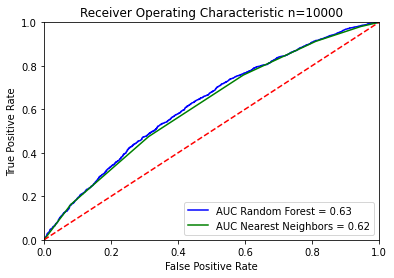

In [13]:
features = [0,1,2,3,4,
            #'prior_question_elapsed_time',
            #'prior_question_had_explanation',
            #'num_watched_lectures', 
            #'num_answered_questions', 
            #'num_correctly_answered_questions', 
            #'ratio_correct_answered'
           ]
target_variable = 'answered_correctly'
clf_parameters = {'n_estimators':1000,
                  'n_jobs':-1}
classifier, feature_importance, _, _ = scenario_test(
    features,
    data=df_user_interactions, 
    sample_size=10000,
    test_share=0.33,
    calc_features=False,
    plt_confusion_matrix=False,
    plt_roc=True,                                 
    **clf_parameters)
#feature_importance

In [14]:
feature_importance

,feature,importance
0,0,0.197190
1,1,0.209948
2,2,0.208312
3,3,0.182533
4,4,0.202017


5 components 0.7 with 2 Mio. '\n'
25 components 0.64 with 100000

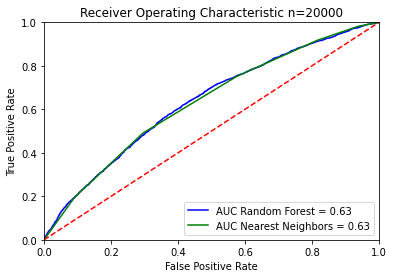

In [15]:
features = [0,1,2,3,4]

target_variable = 'answered_correctly'
clf_parameters = {'n_estimators':1000,
                  'n_jobs':-1}
classifier, feature_importance, _, _ = scenario_test(
    features,
    data=df_user_interactions, 
    sample_size=20000,
    test_share=0.33,
    calc_features=False,
    plt_confusion_matrix=False,
    plt_roc=True,
    **clf_parameters)
#feature_importance

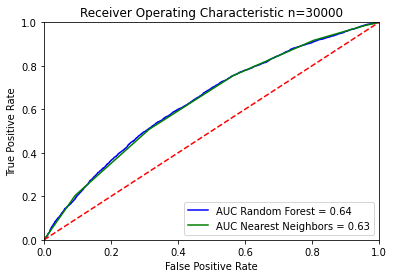

In [16]:
features = [0,1,2,3,4]

target_variable = 'answered_correctly'
clf_parameters = {'n_estimators':1000,
                  'n_jobs':-1}
classifier, feature_importance, _, _ = scenario_test(
    features,
    data=df_user_interactions, 
    sample_size=30000,
    test_share=0.33,
    calc_features=False,
    plt_confusion_matrix=False,
    plt_roc=True,
    **clf_parameters)
#feature_importance

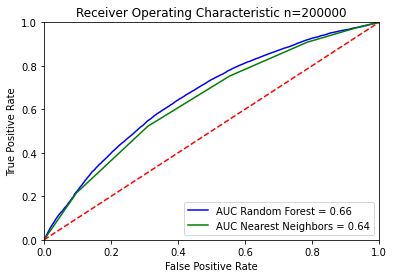

In [17]:
features = [0,1,2,3,4]

target_variable = 'answered_correctly'
clf_parameters = {'n_estimators':1000,
                  'n_jobs':-1}
classifier, feature_importance, _, _ = scenario_test(
    features,
    data=df_user_interactions, 
    sample_size=200000,
    test_share=0.33,
    calc_features=False,
    plt_confusion_matrix=False,
    plt_roc=True,
    **clf_parameters)
#feature_importance

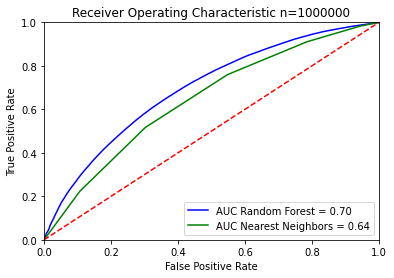

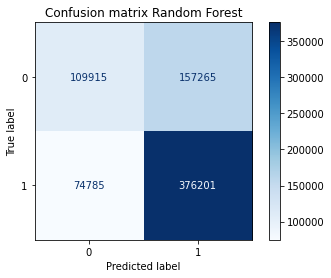

In [18]:
features = [0,1,2,3,4]

target_variable = 'answered_correctly'
clf_parameters = {'n_estimators':1000,
                  'n_jobs':-1}
classifier, feature_importance, _, _ = scenario_test(
    features,
    data=df_user_interactions, 
    sample_size=1000000,
    test_share=0.33,
    calc_features=False,
    plt_confusion_matrix=True,
    plt_roc=True,                                 
    **clf_parameters)


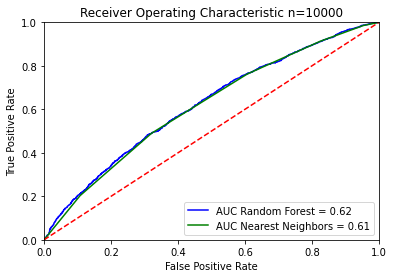

,feature,importance
0,0,0.200213
1,1,0.197542
2,2,0.202994
3,3,0.179546
4,4,0.185284
5,num_watched_lectures,0.010850
6,num_answered_questions,0.021922
7,num_correctly_answered_questions,0.000795
8,ratio_correct_answered,0.000854


In [19]:
features = [0,1,2,3,4,
            'num_watched_lectures', 
            'num_answered_questions', 
            'num_correctly_answered_questions', 
            'ratio_correct_answered'
           ]
target_variable = 'answered_correctly'
clf_parameters = {'n_estimators':1000,
                  'n_jobs':-1}
classifier, feature_importance, _, _ = scenario_test(
    features,
    data=df_user_interactions, 
    sample_size=10000,
    test_share=0.33,
    calc_features=True,
    plt_confusion_matrix=False,
    plt_roc=True,                                 
    **clf_parameters)
feature_importance

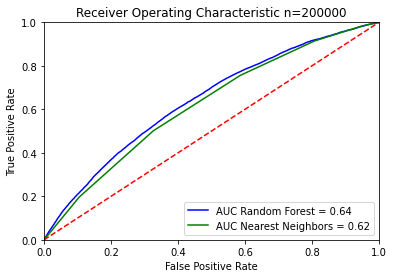

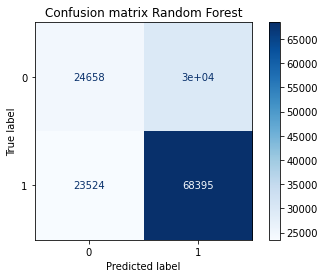

,feature,importance
0,0,0.134744
1,1,0.140838
2,2,0.146786
3,3,0.115798
4,4,0.124738
5,num_watched_lectures,0.129375
6,num_answered_questions,0.188545
7,num_correctly_answered_questions,0.007816
8,ratio_correct_answered,0.011358


In [20]:
features = [0,1,2,3,4,
            'num_watched_lectures', 
            'num_answered_questions', 
            'num_correctly_answered_questions', 
            'ratio_correct_answered'
           ]
target_variable = 'answered_correctly'
clf_parameters = {'n_estimators':1000,
                  'n_jobs':-1}
classifier, feature_importance, _, _ = scenario_test(
    features,
    data=df_user_interactions, 
    sample_size=200000,
    test_share=0.33,
    calc_features=True,
    plt_confusion_matrix=True,
    plt_roc=True,                                 
    **clf_parameters)
feature_importance

In [21]:
features = [0,1,2,3,4]

target_variable = 'answered_correctly'
clf_parameters = {'n_estimators':1000,
                      'n_jobs':-1}

sample_size_list = [1000,3333,6666,10000,33333,66666,100000,333333,666666,1000000,3333333,6666666]
rf_auc_list = list()
lr_auc_list = list()

for sample_size in sample_size_list:
    classifier, feature_importance, rf_auc, lr_auc = scenario_test(
        features,
        data=df_user_interactions, 
        sample_size=sample_size,
        test_share=0.33,
        calc_features=False,
        plt_confusion_matrix=False,
        plt_roc=False,                                 
        **clf_parameters)
    rf_auc_list.append(rf_auc)
    lr_auc_list.append(lr_auc)

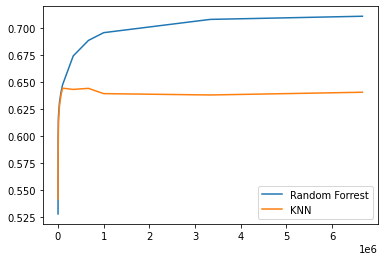

In [27]:
df_eval = pd.DataFrame(data={'Random Forrest': rf_auc_list, 'KNN': lr_auc_list})
df_eval.index = sample_size_list
lines = df_eval.plot.line()

In [23]:
df_eval

,Random Forrest,Log_Reg
1000,0.527714,0.541532
3333,0.598690,0.582103
6666,0.608731,0.596519
10000,0.618225,0.612825
33333,0.631515,0.628471
66666,0.640818,0.637975
100000,0.647479,0.644366
333333,0.674268,0.643214
666666,0.688651,0.644193
1000000,0.695851,0.639295


In [24]:
features = [0,1,2,3,4]
target_variable = 'answered_correctly'


rf_estimator_list = list()

for n_estimators in range(100,2000,100):
    clf_parameters = {'n_estimators':n_estimators,
                      'n_jobs':-1}
    classifier, feature_importance, rf_auc, lr_auc = scenario_test(
        features,
        data=df_user_interactions, 
        sample_size=100000,
        test_share=0.33,
        calc_features=False,
        plt_confusion_matrix=False,
        plt_roc=False,                                 
        **clf_parameters)
    rf_estimator_list.append(rf_auc)


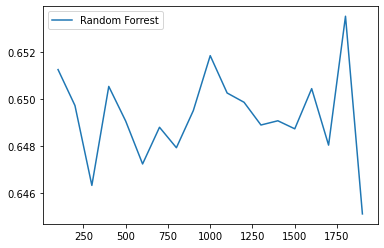

In [25]:
df_eval = pd.DataFrame(data={'Random Forrest': rf_estimator_list})
df_eval.index = range(100,2000,100)
lines = df_eval.plot.line()

In [26]:
df_eval

,Random Forrest
100,0.651250
200,0.649718
300,0.646312
400,0.650532
500,0.649055
600,0.647226
700,0.648791
800,0.647918
900,0.649502
1000,0.651845
